In [40]:
import numpy as np
import pandas as pd
import xarray as xr
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [41]:
ds_fii = xr.open_dataset('dataset/cvm/dataset_cvm_metrica_mensal.nc').fillna(0)
df_dados_fii = pd.read_csv('dataset/cvm/dataset_cvm_metrica_mensal_dados.csv', index_col='CNPJ_Fundo')

In [42]:
lista_cnpj_meses = ds_fii.Acoes.sel(metrica='number_of_nodes').to_pandas()

In [43]:
list_metricas = ['average_clustering', 'coefficient_distribution_degree', 'density', 'average_degree', 'average_short_path']#, 'number_of_nodes']
#list_metricas = ['average_clustering', 'density', 'average_degree']

list_variables_a = [
    #'Patrimonio_Liquido',
    #'Cotas_Emitidas',
    #'Valor_Patrimonial_Cotas',
    'Percentual_Rentabilidade_Efetiva_Mes',
    'Percentual_Rentabilidade_Patrimonial_Mes',
    #'Percentual_Dividend_Yield_Mes',
    #'Percentual_Amortizacao_Cotas_Mes',
]


list_variables_b = [
    'Valor_Ativo',
    'Percentual_Despesas_Taxa_Administracao',
    'Percentual_Despesas_Agente_Custodiante',
    'Total_Necessidades_Liquidez',
    'Disponibilidades',
    'Titulos_Publicos',
    'Titulos_Privados',
    'Fundos_Renda_Fixa',
    'Total_Investido',
    'Direitos_Bens_Imoveis',
    'Terrenos',
    'Imoveis_Renda_Acabados',
    'Imoveis_Renda_Construcao',
    'Imoveis_Venda_Acabados',
    'Imoveis_Venda_Construcao',
    'Outros_Direitos_Reais',
    'Acoes',
    'Debentures',
    'Bonus_Subscricao',
    'Certificados_Deposito_Valores_Mobiliarios',
    'Cedulas_Debentures',
    'Fundo_Acoes',
    'FIP',
    'FII',
    'FDIC',
    'Outras_Cotas_FI',
    'Notas_Promissorias',
    'Acoes_Sociedades_Atividades_FII',
    'Cotas_Sociedades_Atividades_FII',
    'CEPAC',
    'CRI',
    'Letras_Hipotecarias',
    'LCI',
    'LIG',
    'Outros_Valores_Mobliarios',
    'Valores_Receber',
    'Contas_Receber_Aluguel',
    'Contas_Receber_Venda_Imoveis',
    'Outros_Valores_Receber',
    'Rendimentos_Distribuir',
    'Taxa_Administracao_Pagar',
    'Taxa_Performance_Pagar',
    'Obrigacoes_Aquisicao_Imoveis',
    'Adiantamento_Venda_Imoveis',
    'Adiantamento_Alugueis',
    'Obrigacoes_Securitizacao_Recebiveis',
    'Instrumentos_Financeiros_Derivativos',
    'Provisoes_Contigencias',
    'Outros_Valores_Pagar',
    'Total_Passivo',
 ]

list_variables = list_variables_a + list_variables_b

list_cat = [
    #'Mandato',
    #'Segmento_Atuacao',
    #'Publico_Alvo',
    #'Tipo_Gestao',
]

In [44]:
df_fii = ds_fii.sel(metrica=list_metricas).to_array().sel(CNPJ_Fundo=(ds_fii.Acoes.sel(metrica='number_of_nodes') >= 48).values).sel(variable=list_variables).stack(var=['variable', 'metrica']).to_pandas()
df_fii['TIR'] = df_dados_fii['TIR'].fillna(-1)
df_fii_cat =  df_dados_fii[list_cat]
df_fii = df_fii[(df_fii[('TIR','')] <= 1) & (df_fii[('TIR','')] >= -1)]

In [45]:
features = StandardScaler().fit_transform(df_fii.drop(columns=[('TIR','')]).values)
target = df_fii[('TIR','')].fillna(-1.).values.reshape(-1, 1)

features.shape

(358, 260)

In [66]:
X, y = np.hstack((features, features**2)), target
X, y = features, target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2/3, random_state=0)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test  = torch.tensor(X_test,  dtype=torch.float32, device=device)
y_test  = torch.tensor(y_test,  dtype=torch.float32, device=device)

# Define the model
model = nn.Sequential(
    nn.Linear(X_train.shape[1]  , X_train.shape[1]*2),
    nn.ReLU(),
    nn.Linear(X_train.shape[1]*2, X_train.shape[1]*2),
    nn.ReLU(),
    nn.Linear(X_train.shape[1]*2, 1),
).to(device)


# loss function and optimizer
loss_fn = nn.L1Loss()  # mean absolute error
optimizer = optim.SGD(model.parameters(), lr=3e-2, weight_decay=5e-3)

n_epochs = 10000   # number of epochs to run
batch_size = 8   # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mae = np.inf   # init to infinity
best_weights = None
history_train = []
history_test = []

for epoch in range(n_epochs):
    model.train()
    for start in batch_start:
        # take a batch
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        # forward pass
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
    # evaluate accuracy at end of each epoch
    model.eval()

    y_pred = model(X_train)
    mae_train = loss_fn(y_pred, y_train)
    mae_train = float(mae_train)
    history_train.append(mae_train)

    y_pred = model(X_test)
    mae_test = loss_fn(y_pred, y_test)
    mae_test = float(mae_test)
    history_test.append(mae_test)
    
    if epoch%500 == 0:
        print(f'Epoch: {epoch:4d} MAE(train: {mae_train:.3f}, test: {mae_test:.3f})')

    if mae_test < best_mae:
        best_mae = mae_test
        best_weights = copy.deepcopy(model.state_dict())
        
last_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print(f'\nMAE: {best_mae:.3f}')

Epoch:    0 MAE(train: 0.161, test: 0.204)
Epoch:  500 MAE(train: 0.019, test: 0.195)
Epoch: 1000 MAE(train: 0.018, test: 0.200)
Epoch: 1500 MAE(train: 0.015, test: 0.192)
Epoch: 2000 MAE(train: 0.017, test: 0.191)
Epoch: 2500 MAE(train: 0.014, test: 0.199)
Epoch: 3000 MAE(train: 0.032, test: 0.192)
Epoch: 3500 MAE(train: 0.014, test: 0.198)
Epoch: 4000 MAE(train: 0.026, test: 0.206)
Epoch: 4500 MAE(train: 0.015, test: 0.196)
Epoch: 5000 MAE(train: 0.012, test: 0.201)
Epoch: 5500 MAE(train: 0.022, test: 0.198)
Epoch: 6000 MAE(train: 0.019, test: 0.203)
Epoch: 6500 MAE(train: 0.016, test: 0.199)
Epoch: 7000 MAE(train: 0.024, test: 0.204)
Epoch: 7500 MAE(train: 0.020, test: 0.193)
Epoch: 8000 MAE(train: 0.020, test: 0.197)
Epoch: 8500 MAE(train: 0.022, test: 0.199)
Epoch: 9000 MAE(train: 0.021, test: 0.207)
Epoch: 9500 MAE(train: 0.023, test: 0.195)

MAE: 0.184


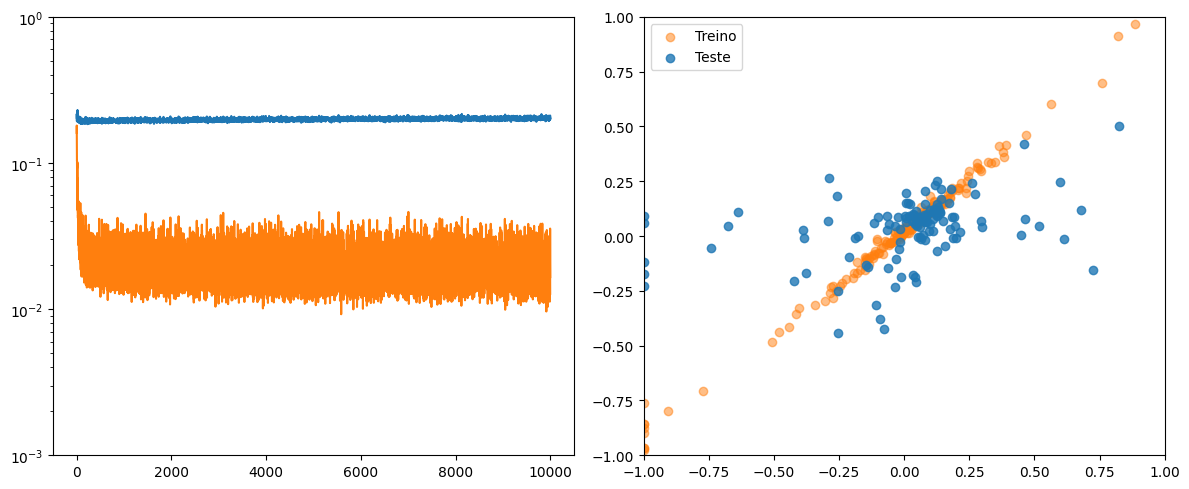

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history_test, label='Teste')
ax1.plot(history_train, label='Treino')
ax1.set_yscale('log')
ax1.set_ylim((1e-3, 1e0))

ax2.scatter(y_train.cpu(), torch.Tensor.numpy(model(X_train).cpu(), force=True), alpha=0.5, c='tab:orange', label='Treino')
ax2.scatter(y_test.cpu(), torch.Tensor.numpy(model(X_test).cpu(), force=True), alpha=0.8, c='tab:blue', label='Teste')
ax2.set_xlim((-1,1))
ax2.set_ylim((-1,1))

plt.legend(loc='best')
plt.tight_layout()
plt.show()

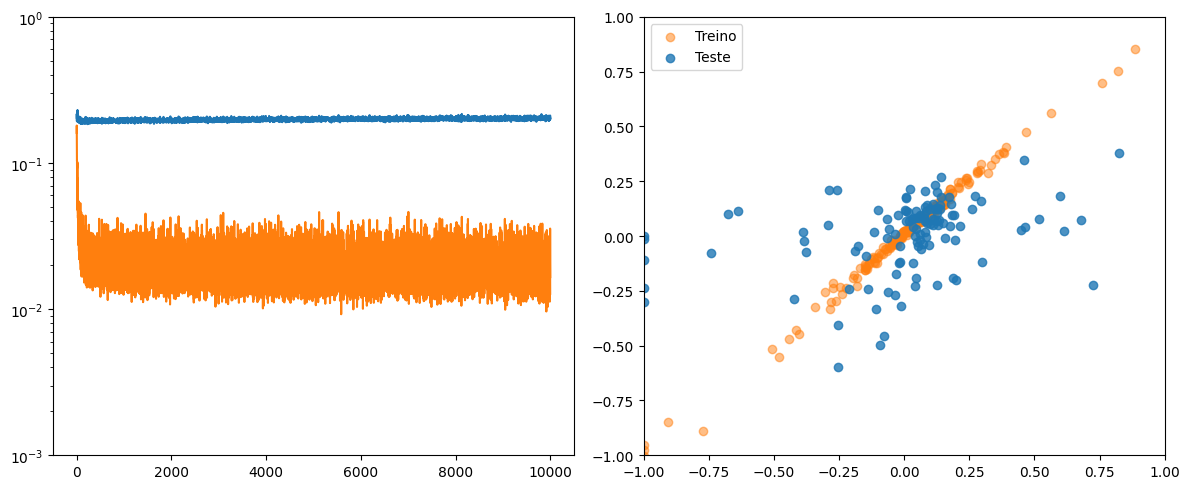

In [68]:
model.load_state_dict(last_weights)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history_test, label='Teste')
ax1.plot(history_train, label='Treino')
ax1.set_yscale('log')
ax1.set_ylim((1e-3, 1e0))

ax2.scatter(y_train.cpu(), torch.Tensor.numpy(model(X_train).cpu(), force=True), alpha=0.5, c='tab:orange', label='Treino')
ax2.scatter(y_test.cpu(), torch.Tensor.numpy(model(X_test).cpu(), force=True), alpha=0.8, c='tab:blue', label='Teste')
ax2.set_xlim((-1,1))
ax2.set_ylim((-1,1))

plt.legend(loc='best')
plt.tight_layout()
plt.show()